In [3]:
#NOTE IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
import pandas as pd # Dataframe
import seaborn as sns # Boxplot

In [4]:
#NOTE CONSTANTS

AZIMUTH_MIN     = -180 # "under"-rotation
AZIMUTH_MAX     = 540 # with over-rotation
ELEVATION_MIN   = 15 # balcony ground collision at <=14°
ELEVATION_MAX   = 165 # flip-over
AZ_SPEED        = 1.6 # degrees per second, practically tested
EL_SPEED        = 1.3


waypoints = [
    #AZ     EL
    (0,     15), # parking position
    (350,   30),
    (180,   85),
    (0,     85),
    (90,    60),
    (10,    20),
    (270,   80),
    (45,    40),
    (165,   40),
]

In [5]:
#NOTE COORDINATE TRANSFORMATION

def azel_to_cartesian(az_deg: float, el_deg: float) -> np.ndarray:
    az = np.radians(az_deg)
    el = np.radians(el_deg)
    # standard unit spherical coordinates
    x = np.cos(el) * np.cos(az)
    y = np.cos(el) * np.sin(az)
    z = np.sin(el)
    return np.array([x, y, z])


def cartesian_to_azel(vec: np.ndarray) -> Tuple[float, float]:
    x, y, z = vec
    hyp = np.hypot(x, y) # hypotenuse = sqrt(x**2 + y**2)
    az = np.degrees(np.arctan2(y, x)) % 360 # full-circle azimuth
    el = np.degrees(np.arctan2(z, hyp))
    return az, el


def azel_to_polar(az_deg: float, el_deg: float) -> Tuple[float, float]:
    if el_deg > 90:
        el_deg = 180 - el_deg # flip over adjusting
    theta = np.radians(az_deg % 360)
    radius = 90 - el_deg # center = el_90
    return theta, radius

In [6]:
#NOTE SLERP

def slerp_path(start_az: float, start_el: float, end_az: float, end_el: float, steps: int = 1000) -> List[Tuple[float, float]]:
    # convert to 3D vectors
    p0 = azel_to_cartesian(start_az, start_el)
    p1 = azel_to_cartesian(end_az, end_el)

    # angle between start/end vector in radians
    # dot product of 2 unit vectors => cos(omega) (since theta will be used for polar)
    omega = np.arccos(np.clip(np.dot(p0, p1), -1.0, 1.0)) # ensure it stays between -1 and 1

    # small angles ~ linear anyway
    if np.isclose(omega, 0):
        return [(start_az, start_el)] * steps

    # otherwise calculate steps along the path
    sin_omega = np.sin(omega)
    path = []

    # formula: point(t) = [sin((1-t)*omega)*p0 + sin(t*omega)*p1]/sin(omega) -> sin() = weights
    # no weights -> cut through circle, like |x| + |y| + |z|
    # interpolate along spherical arc
    for t in np.linspace(0, 1, steps):
        factor0 = np.sin((1-t) * omega) / sin_omega
        factor1 = np.sin(t * omega) / sin_omega
        pt = factor0 * p0 + factor1 * p1
        az, el = cartesian_to_azel(pt) # reverse coordinate after calculation of path
        path.append((az, el))
    return path

In [7]:
#NOTE AXIS ALIGNED PATH

def axis_aligned_paths(start: Tuple[float, float], end: Tuple[float, float]) -> List[Tuple[str, List[Tuple[float, float]]]]:
    paths = []
    az_s, el_s = start
    az_e, el_e = end

    az_path1 = slerp_path(az_s, el_s, az_e, el_s, steps=100)
    el_path1 = slerp_path(az_e, el_s, az_e, el_e, steps=100)
    paths.append(("AZ->EL", az_path1 + el_path1))

    az_path2 = slerp_path(az_s, el_s, az_s, el_e, steps=100)
    el_path2 = slerp_path(az_s, el_e, az_e, el_e, steps=100)
    paths.append(("EL->AZ", az_path2 + el_path2))

    return paths

In [8]:
#NOTE SIMULTANEOUS PATH WITHOUT OVER/UNDERROTATION OR FLIP-OVER

def simultaneous_az_el_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> List[Tuple[float, float]]:
    az1, el1 = start
    az2, el2 = end

    az_vals = np.linspace(az1, az2, steps)
    el_vals = np.linspace(el1, el2, steps)

    az_vals = np.mod(az_vals, 360.0)

    return list(zip(az_vals, el_vals))

In [9]:
#NOTE MOVEMENT TIME CALCULATION

def movement_time(start: Tuple[float, float], end: Tuple[float, float], sequential: bool = False) -> float:
    # Extract coordinates
    az_start, el_start = start
    az_end, el_end = end

    # Shortest distances for AZ/EL
    delta_az = min(abs(az_end - az_start), 360 - abs(az_end - az_start))
    delta_el = abs(el_end - el_start)

    time_az = delta_az / AZ_SPEED
    time_el = delta_el / EL_SPEED

    if sequential:
        return time_az + time_el # Separate movement
    else:
        return max(time_az, time_el) # Simultaneous AZ/EL movement


def slerp_path_time(path: List[Tuple[float, float]], sequential: bool = False) -> float:
    total_time = 0.0
    for i in range(1, len(path)):
        total_time += movement_time(path[i-1], path[i], sequential)
    return total_time


def axis_aligned_time(start: Tuple[float, float], end: Tuple[float, float]) -> Tuple[float, float]:
    az_to_el = (
        movement_time(start, (end[0], start[1]), sequential=False) + movement_time((end[0], start[1]), end, sequential=False)
        )

    el_to_az = (
        movement_time(start, (start[0], end[1]),sequential=False) + movement_time((start[0], end[1]), end, sequential=False)
    )
    return az_to_el, el_to_az

In [10]:
#NOTE MAIN, COLLECTS ALL PATHS

def calc_paths(waypoints=waypoints):
    all_paths = []
    for i in range(len(waypoints) -1): 
        start = waypoints[i]
        end = waypoints[i + 1]

        # SLERP path and time
        path_slerp = slerp_path(*start, *end, steps=500)
        time_slerp = slerp_path_time(path_slerp)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "SLERP",
            "Time (s)": round(time_slerp, 2),
            "Path": path_slerp
            })

        # Axis-aligned paths and times
        for name, path in axis_aligned_paths(start, end):
            time_axis = slerp_path_time(path, sequential=True)
            all_paths.append({
                "From": start,
                "To": end,
                "Path Type": name,
                "Time (s)": round(time_axis, 2),
                "Path": path
            })

        # Simultaneous AZ+EL path
        path_simult = simultaneous_az_el_path(start, end, steps=500)
        time_simult = slerp_path_time(path_simult)
        all_paths.append({
            "From": start,
            "To": end,
            "Path Type": "AZ+EL Simult",
            "Time (s)": round(time_simult, 2),
            "Path": path_simult
        })
    return all_paths

all_paths = calc_paths()

In [11]:
#NOTE DATAFRAME CONVERSION

def dataframe_conv(all_paths = all_paths):
    df = pd.DataFrame(all_paths)
    df["From"] = df["From"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))
    df["To"] = df["To"].apply(lambda t: (round(t[0], 1), round(t[1], 1)))

    #print(df[["From", "To", "Path Type", "Time (s)"]].to_string(index=False))

    # Statistics
    # Group by coordinate pair -> select time column -> find index (row number) with minimum time -> loc selects actual rows after they are found
    fastest_per_segment = df.loc[df.groupby(["From", "To"])["Time (s)"].idxmin()]
    print(f"\nFastest per segment:\n{fastest_per_segment[["From", "To", "Path Type", "Time (s)"]]}")

    # Best
    win_counts = fastest_per_segment["Path Type"].value_counts()
    print(f"\nWin counts by {win_counts}")

    # Average Time per path type
    avg_times = df.groupby("Path Type")["Time (s)"].mean().sort_values()
    print(f"\nAverage Times:\n{avg_times}")
    return df

df = dataframe_conv()


Fastest per segment:
         From         To     Path Type  Time (s)
0     (0, 15)  (350, 30)         SLERP     11.54
15    (0, 85)   (90, 60)  AZ+EL Simult     56.25
20   (10, 20)  (270, 80)         SLERP     86.00
31   (45, 40)  (165, 40)  AZ+EL Simult     75.00
19   (90, 60)   (10, 20)  AZ+EL Simult     50.00
11  (180, 85)    (0, 85)  AZ+EL Simult    112.50
24  (270, 80)   (45, 40)         SLERP     99.73
7   (350, 30)  (180, 85)  AZ+EL Simult    106.25

Win counts by Path Type
AZ+EL Simult    5
SLERP           3
Name: count, dtype: int64

Average Times:
Path Type
SLERP            81.50125
EL->AZ          105.39500
AZ->EL          110.75000
AZ+EL Simult    115.23375
Name: Time (s), dtype: float64


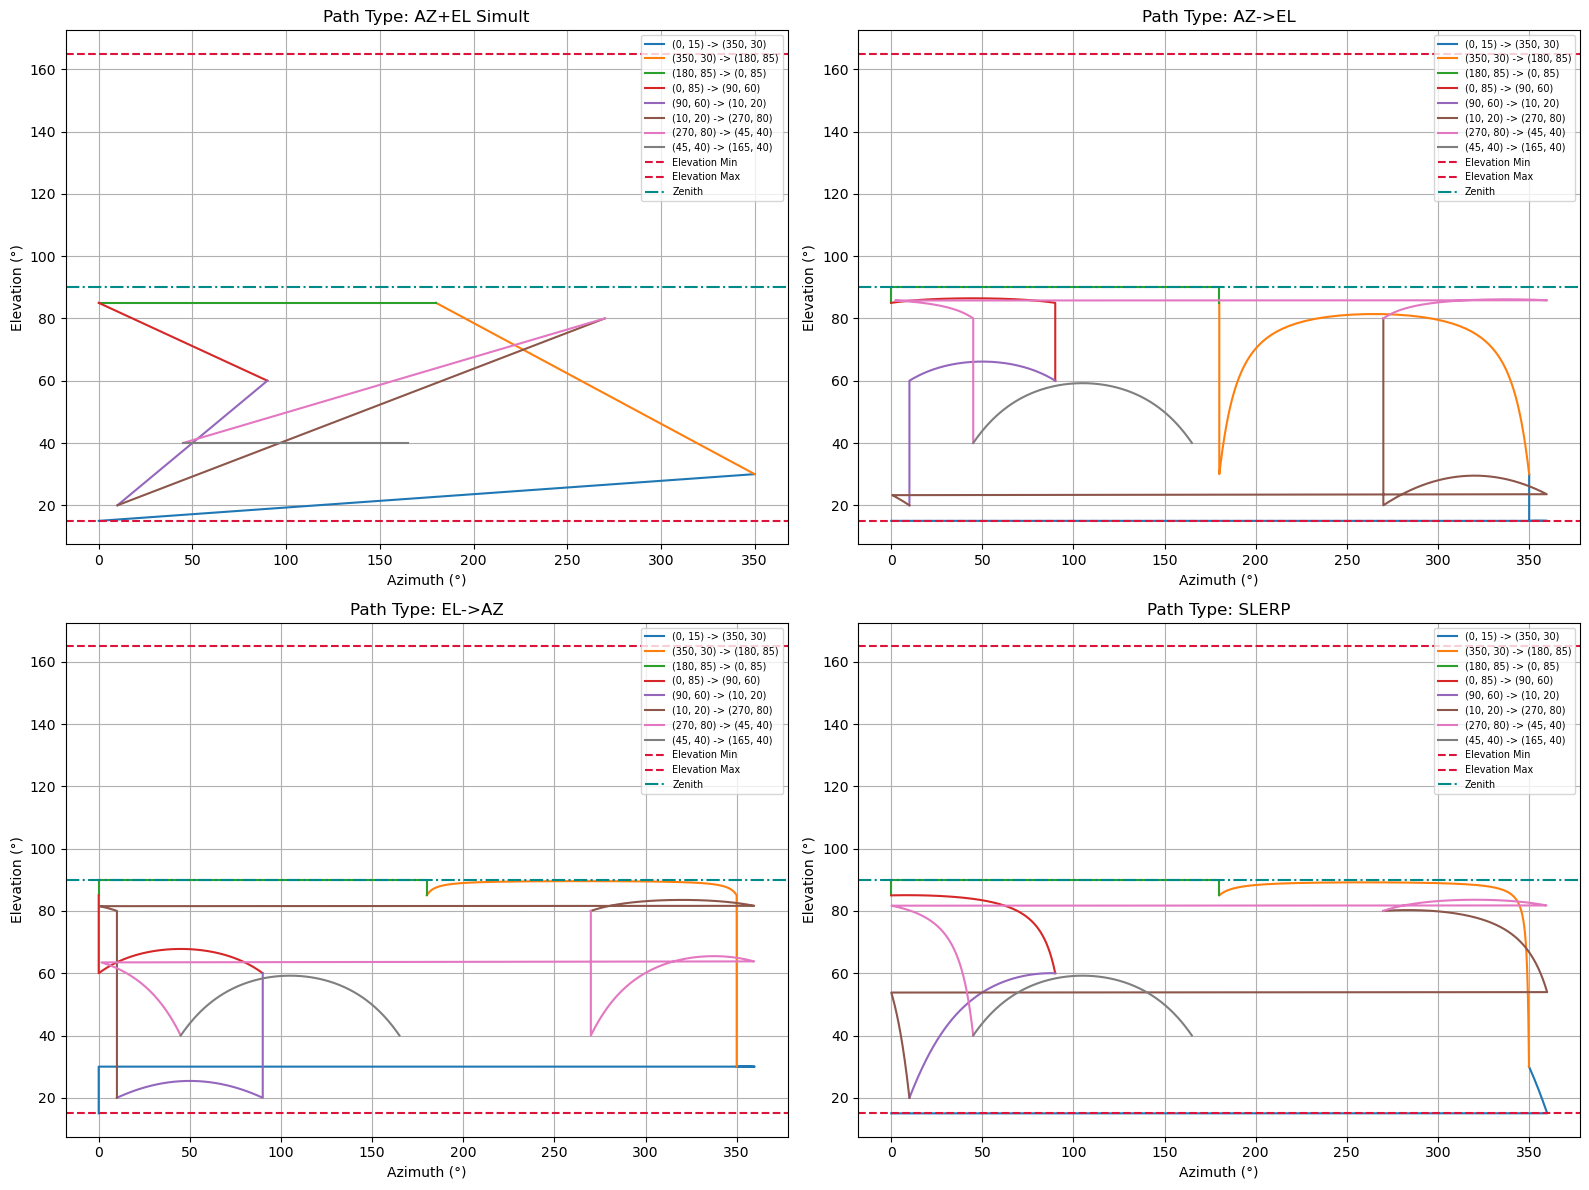

In [12]:
#NOTE 2D-AZEL-PROJECTED PLOT

path_types = sorted(set(entry["Path Type"] for entry in all_paths))

rows = 2
cols = int(np.ceil(len(path_types) / 2))
fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), subplot_kw={"polar": False})
axes = axes.flat


for ax, path_type in zip(axes, path_types):
    for i, entry in enumerate(all_paths):
        if entry["Path Type"] == path_type:
            path = entry["Path"]
            az_list, el_list = zip(*path)
            ax.plot(az_list, el_list, label=f"{entry['From']} -> {entry['To']}")

    ax.set_title(f"Path Type: {path_type}")
    ax.set_xlabel("Azimuth (°)")
    ax.set_ylabel("Elevation (°)")
    ax.axhline(y=ELEVATION_MIN, color="crimson", linestyle="--", label="Elevation Min")
    ax.axhline(y=ELEVATION_MAX, color="crimson", linestyle="--", label="Elevation Max")
    ax.axhline(y=90, color="darkcyan", linestyle="-.", label="Zenith")
    ax.grid(True)
    ax.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

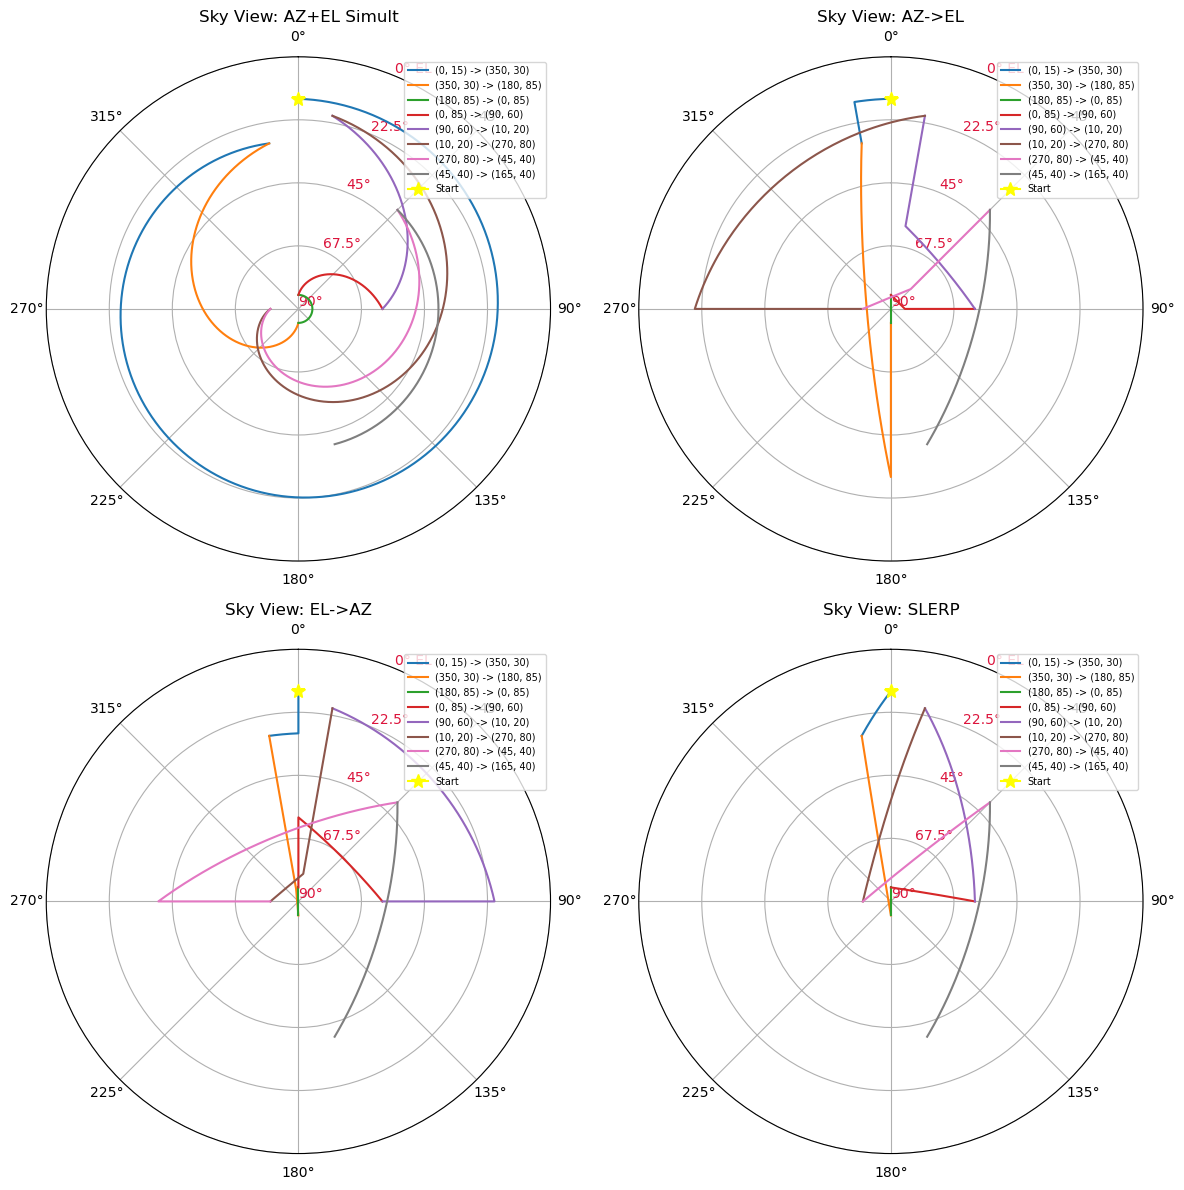

In [13]:
#NOTE POLAR-PROJECTED PLOTS

def polar_proj():
    rows = 2
    cols = int(np.ceil(len(path_types) / 2))
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows), subplot_kw={"polar": True})
    axes = axes.flat

    for ax, path_type in zip(axes, path_types):
        for i, entry in enumerate(all_paths):
            if entry["Path Type"] == path_type:
                path = entry["Path"]
                theta_and_r = [azel_to_polar(az, el) for az, el in path]
                theta, r = zip(*theta_and_r)
                from_coord = tuple(round(x, 2) for x in entry["From"])
                to_coord = tuple(round(y, 2) for y in entry["To"])
                ax.plot(theta, r, label=f"{from_coord} -> {to_coord}")

        # Starting point
        theta0, r0 = azel_to_polar(*waypoints[0])
        ax.plot([theta0], [r0], marker="*", markersize=10, color="yellow", label="Start")

        # Subplot formatting
        ax.set_title(f"Sky View: {path_type}")
        ax.set_ylim(0, 75)
        ax.set_yticks([0, 22.5, 45, 67.5, 90])
        ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0° EL"])
        for label in ax.get_yticklabels():
            label.set_color("crimson")
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.grid(True)
        
        ax.legend(loc="upper right", fontsize="x-small")

    plt.tight_layout()
    plt.show()
    return

polar_proj()

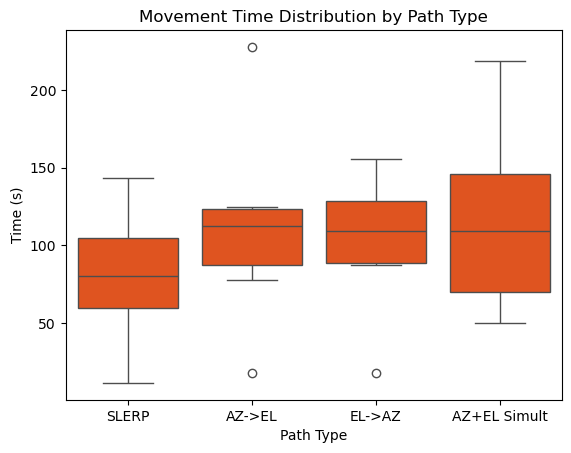

In [14]:
#NOTE BOXPLOT

sns.boxplot(data=df, x="Path Type", y="Time (s)", color="orangered")
plt.title("Movement Time Distribution by Path Type")
plt.show()

In [15]:
#NOTE WAYPOINT GENERATOR + CALCULATING TIME FOR EACH WAYPOINT

def random_waypoints(n: int = 10) -> List[Tuple[float, float]]:
    az = np.random.uniform(0, 360, n)
    el = np.random.uniform(ELEVATION_MIN, 90.0, n)

    return list(zip(az, el))


def benchmark_segment(wps: List[Tuple[float, float]]):
    method_times = {
        "SLERP": [],
        "AZ->EL": [],
        "EL->AZ": [],
        "AZ+EL Simult": []
        }

    # Waypoint pairs for moving
    for i in range(len(wps) - 1):
        s, e = wps[i], wps[i + 1]

        method_times["SLERP"].append(slerp_path_time(slerp_path(*s, *e, steps=100)))

        azel_time, elaz_time = axis_aligned_time(s, e)
        method_times["AZ->EL"].append(azel_time)
        method_times["EL->AZ"].append(elaz_time)

        sim_path = simultaneous_az_el_path(s, e, steps=100)
        method_times["AZ+EL Simult"].append(slerp_path_time(sim_path))

    return method_times

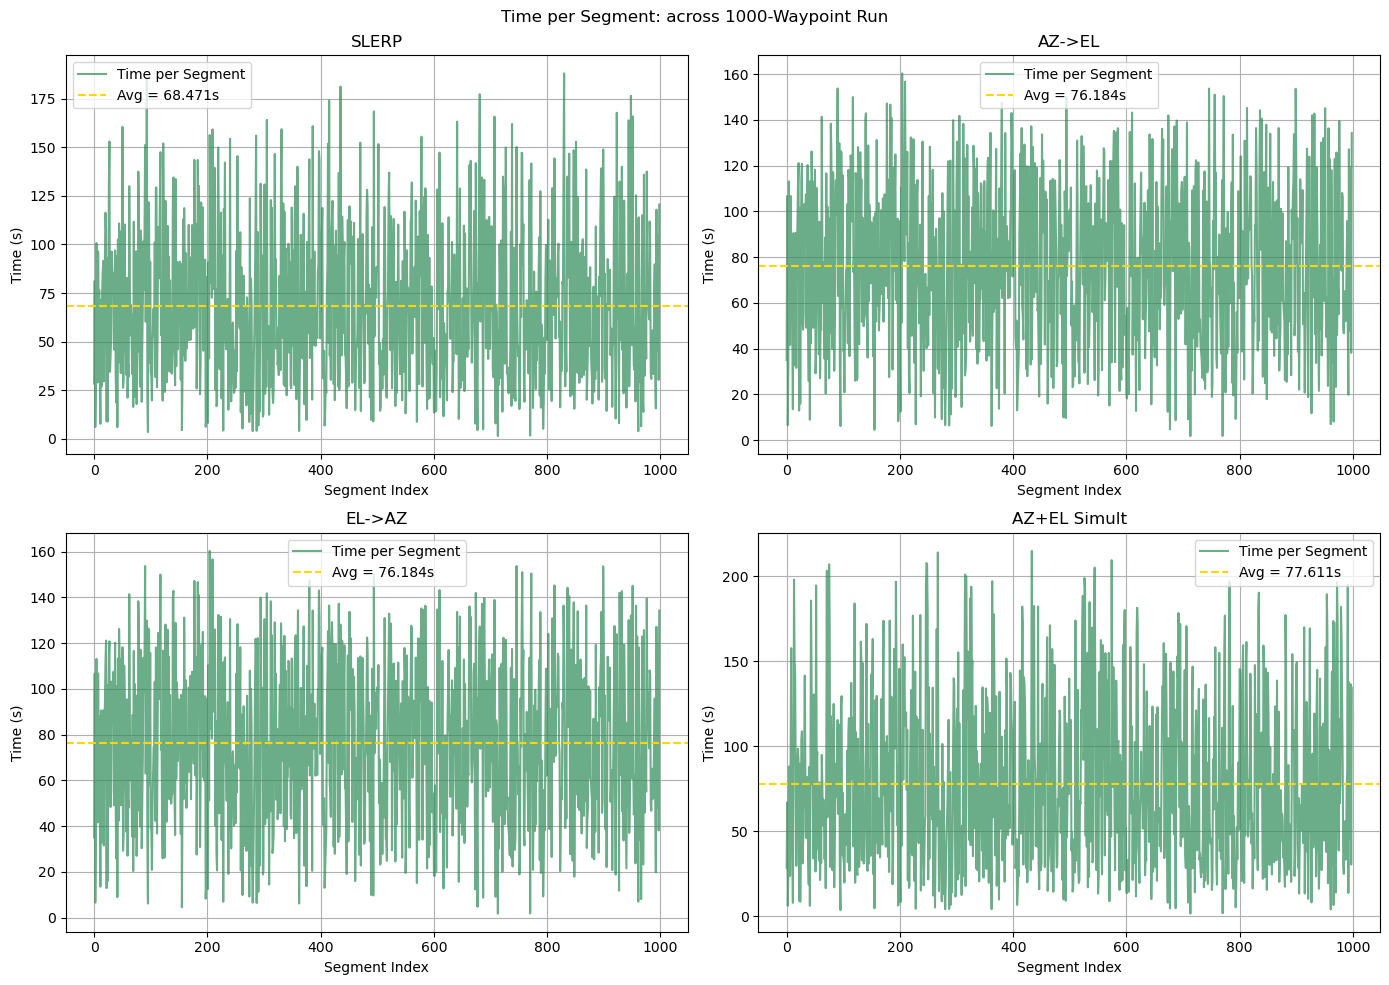

In [16]:
#NOTE PLOT LONG TERM BEHAVIOUR

def plot_time_per_segment(method_times: dict, n: int=10):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for i, (method, times) in enumerate(method_times.items()):
        ax = axs[i]
        x = np.arange(len(times))
        y = np.array(times)

        ax.plot(x, y, label="Time per Segment", alpha=0.7, color="seagreen")
        ax.axhline(np.mean(y), color="gold", linestyle="--", label=f"Avg = {np.mean(y):.3f}s")

        ax.set_title(method)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Segment Index")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Time per Segment: across {n}-Waypoint Run")
    plt.tight_layout()
    plt.show()

N = 1000 # ADJUST HERE
wps = random_waypoints(N)
segment_times = benchmark_segment(wps)
plot_time_per_segment(segment_times, N)

In [17]:
#NOTE AVG DIFFS BETWEEN AXES

def average_delta(wps):
    total_az = 0
    total_el = 0
    for i in range(len(wps) - 1):
        az1, el1 = wps[i]
        az2, el2 = wps[i + 1]
        delta_az = min(abs(az2 - az1), 360 - abs(az2 - az1))
        delta_el = abs(el2 - el1)
        total_az += delta_az
        total_el += delta_el
    return total_az / (len(wps) - 1), total_el / (len(wps) - 1)

print("fixed  avg deltas", average_delta(waypoints))
print("random avg deltas", average_delta(wps))

fixed  avg deltas (110.625, 29.375)
random avg deltas (91.89241506027017, 24.376433376095484)


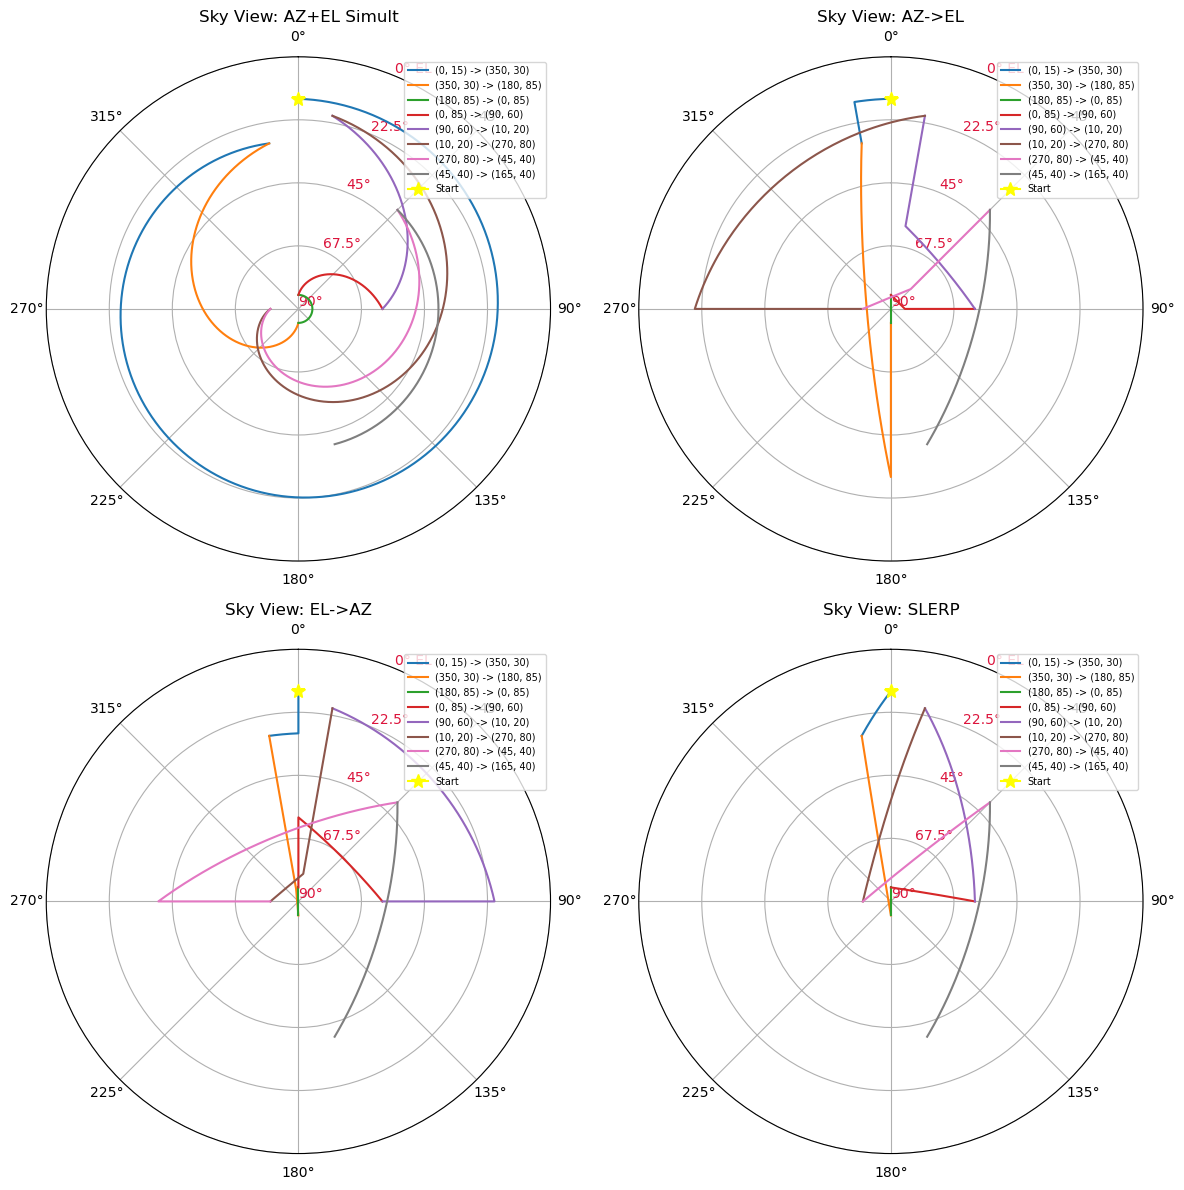

In [18]:
#NOTE PATH SHOWCASE OF RANDOM WPTS

wpts = random_waypoints(n=10)

all_paths2 = calc_paths(waypoints=wpts)

polar_proj()


Fastest per segment:
                From             To     Path Type  Time (s)
30832    (0.0, 57.5)  (206.1, 57.9)         SLERP    102.64
18211    (0.1, 20.6)  (127.4, 73.0)  AZ+EL Simult     79.60
30788    (0.1, 62.3)  (265.9, 62.3)         SLERP     58.87
29539    (0.1, 80.6)   (83.3, 61.1)  AZ+EL Simult     51.97
16163    (0.1, 84.4)   (49.3, 63.7)  AZ+EL Simult     30.71
...              ...            ...           ...       ...
27015  (359.8, 87.0)  (286.5, 59.7)  AZ+EL Simult     45.84
9071   (359.9, 32.6)  (230.5, 21.3)  AZ+EL Simult     80.89
35672  (359.9, 60.3)  (257.0, 63.4)         SLERP     64.32
24883  (359.9, 86.5)  (231.4, 77.2)  AZ+EL Simult     80.30
2492   (360.0, 44.5)  (149.3, 30.4)         SLERP    103.67

[9999 rows x 4 columns]

Win counts by Path Type
AZ+EL Simult    5528
SLERP           4471
Name: count, dtype: int64

Average Times:
Path Type
SLERP           66.719616
AZ+EL Simult    76.148557
EL->AZ          91.622304
AZ->EL          91.692870
Name: Time

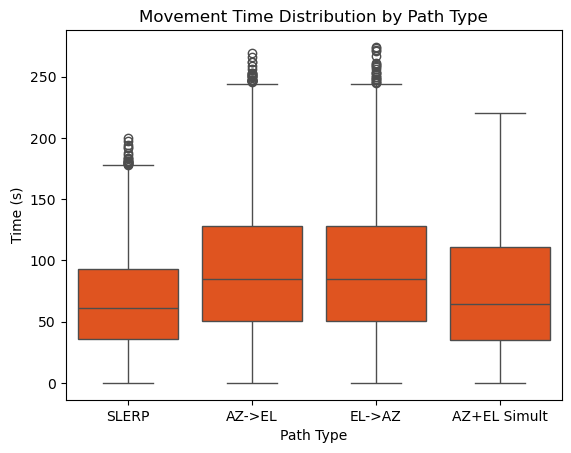

In [19]:
wpts = random_waypoints(n=10000)

all_paths3 = calc_paths(waypoints=wpts)

df3 = dataframe_conv(all_paths=all_paths3)

sns.boxplot(data=df3, x="Path Type", y="Time (s)", color="orangered")
plt.title("Movement Time Distribution by Path Type")
plt.show()

In [20]:
# TODO compare flip-over + overrotation code to non-flip-over + overrotation one
# TODO write that one

In [21]:
#NOTE SIMULT AZEL WITH OVER/UNDERROTATION

def simultaneous_az_el_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> List[Tuple[float, float]]:
    az1, el1 = start
    az2, el2 = end

    delta_az = (az2 - az1 + 540) % 360 - 180
    az_end_adjusted = az1 + delta_az

    path = [
        (az1 + (az_end_adjusted - az1) * t, el1 + (el2 - el1) * t)
        for t in np.linspace(0, 1, steps)
    ]
    return path

In [ ]:
#NOTE SIMULT AZEL WITH OVER/UNDERROTATION AND FLIP-OVER

# Gives angular difference in signed 180 range, thus showing direction [-180.0, 180.0]
def wrap180(az_diff):
    return (az_diff + 180.0) % 360.0 - 180.0




# Returns shortest rotation, positive -> clockwise, negative -> widdershins
def delta_shortest(az1, az2):
    return wrap180(az2 - az1)




# Calculates runtime for slewing telescope
def time_simult(az_abs_diff: float, el_abs_diff: float) -> float:
    t_az = az_abs_diff / AZ_SPEED
    t_el = el_abs_diff / EL_SPEED
    return max(t_az, t_el)




# Constructs straight path for plotting
def straight_path(start: Tuple[float, float], az_diff: float, el_diff: float, steps: int = 500) -> Tuple[float, float]:
    az1, el1 = start
    t = np.linspace(0.0, 1.0, steps)
    az = az1 + az_diff * t
    el = el1 + el_diff * t
    return list(zip(az, el))




# Neither flip-over nor over/underrotate
def normal_path(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = delta_shortest(az1, az2)
    el_diff = el2 - el1
    return {
        "name": "no_flip_no_overr",
        "diffs": (az_diff, el_diff),
        "time": time_simult(abs(az_diff), abs(el_diff)),
        "path": straight_path(start, az_diff, el_diff, steps)
    }




def overrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = (az2 - az1) % 360.0
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "overrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult(abs(az_diff), abs(el_diff)),
        "path": path
    }




def underrotate(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = -((az2 - az1) % 360.0)
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "underrotate",
        "diffs": (az_diff, el_diff),
        "time": time_simult(abs(az_diff), abs(el_diff)),
        "path": path
    }




def flip_over(start: Tuple[float, float], end: Tuple[float, float], steps: int = 500) -> dict:
    az1, el1 = start
    az2, el2 = end
    az_diff = az2 - az1 # not wrapped
    el_diff = el2 - el1
    path = straight_path(start, az_diff, el_diff, steps)
    # Put coordinates back in 0-360
    path = [(az % 360.0, el) for az, el in path]
    return {
        "name": "flip-over",
        "diffs": (az_diff, el_diff),
        "time": time_simult(abs(az_diff), abs(el_diff)),
        "path": path
    }




# UPGRADED LOGIC
def choose_path_logic(start: Tuple[float, float],
                         end: Tuple[float, float],
                         steps: int = 500,
                         az_flip_thresh: float = 150.0,
                         el_flip_thresh: float = 70.0) -> dict:
    az1, el1 = start
    az2, el2 = end

    
    # Determine path baseline values
    az_diff_signed = delta_shortest(az1, az2)

    # Decide if flip-over is useful
    near_zenith = (el1 >= el_flip_thresh) or (el2 >= el_flip_thresh)
    big_az = abs(az_diff_signed) >= az_flip_thresh


    if near_zenith and big_az:
        #TODO flip_over(az1, el1, az2, el2, steps)
        return flip_over(start, end, steps)

    elif (az1 + az_diff_signed > 360.0) and (az1 + az_diff_signed <= 540.0):
        #TODO overrotate(az1, el1, az2, el2, steps)
        return overrotate(start, end, steps)

    elif (az1 + az_diff_signed < 0.0) and (az1 + az_diff_signed >= -180.0):
        #TODO underrotate(az1, el1, az2, el2, steps)
        return underrotate(start, end, steps)

    else:
        # Normal (constrained by limits) movement
        return normal_path(start, end, steps)

#TODO: 
    '''
    flip-over when el start and/or end is over threshold and az_diff is over threshold
        -> go "straight" path between el1 and el2 instead of long rotation
        -> adjust az along the way
        -> no "remembering" yet, telescope makes every movement inddependently
    under/overrotate when az_diff sends telescope over 0 or 360
        -> over/underrotate

    '''











    '''# Helper function to try candidate and keep best otherwise
    def try_candidate(name, az_diff_signed, el_diff_signed, best):
        if not segment_within_az_limits(az1, az_diff_signed):
            return best
        el_end = el1 + el_diff_signed
        if not within_el_limits(el_end):
            return best

        t = time_from_deltas(abs(az_diff_signed), abs(el_diff_signed))


        is_better = (t < best["time_s"] - smol) or (
            abs(t - best["time_s"]) <= smol and abs(az_diff_signed) < abs(best["deltas"][0]) - smol
        )
        if is_better:
            return {
                "name": name,
                "time_s": t,
                "deltas": (az_diff_signed, el_diff_signed),
                "path": straight_path(start, az_diff_signed, el_diff_signed, steps=steps)
            }
        return best

    best = {"name": None, "time_s": float("inf"), "deltas": (0.0, 0.0), "path": []}












def segment_within_az_limits(az_start, az_diff_signed):
    az_end = az_start + az_diff_signed
    return within_az_limits(az_start) and within_az_limits(az_end)


# Maps coordinates to other side of zenith
def flip_map(az, el):
    return az + 180.0, 180.0 - el




def within_el_limits(el):
    return (ELEVATION_MIN <= el <= ELEVATION_MAX)






def within_az_limits(az):
    return (AZIMUTH_MIN <= az <= AZIMUTH_MAX)



# Returns true, if they are on opposite sides of 90°
def crosses_90(el1, el2):
    return (el1 - 90.0) * (el2 - 90.0) < 0.0


    #NOTE NO FLIP CANDIDATES
    el_diff_signed = el2 - el1
    az_diff_short = delta_shortest(az1, az2)

    # no over/underrotation
    best = try_candidate("shortest_no_flip", delta_shortest(az1, az2), el_diff_signed, best)

    # Over/Underrotation (endpoints still within -180° and 540°)

    # Overrotation
    az_diff_signed_pos = (az2 - az1) % 360.0
    if az_diff_signed_pos > 0:
        best = try_candidate("overrotate", az_diff_signed_pos, el_diff_signed, best)

    # Underrotation
    az_diff_signed_neg = -((az1 - az2) % 360.0)
    if az_diff_signed_neg < 0:
        best = try_candidate("underrotate", az_diff_signed_neg, el_diff_signed, best)




    #NOTE FLIP CANDIDATES
    if (abs(az_diff_short) >= az_overr_thresh)



        #NOTE if code triggers this, well it shouldn't
        if best["name"] is None:
            az_diff_signed = delta_shortest(az1, az2)
            el_diff_signed = el2 - el1
            best = try_candidate("WARNING", az_diff_signed, el_diff_signed, best)

    return best'''

In [ ]:
#NOTE PLOT



'''
pairs = wpts if 'wpts' in globals() else waypoints

MAX_SEGMENTS = 15
idxs = np.arange(min(len(pairs)-1, MAX_SEGMENTS))

comp = []
for i in idxs:
    s, e = pairs[i], pairs[i+1]

     # baseline
    p_sim = simultaneous_az_el_path(s, e, steps=400)
    comp.append(("AZ+EL Simult", s, e, p_sim))

    # upgraded (assumes upgraded_azel_simult returns dict with 'name' and 'path')
    upg = upgraded_azel_simult(s, e, steps=400)
    comp.append((f"Upgraded ({upg['name']})", s, e, upg["path"]))

show_legend = len(idxs) <= 12  # only show legend if few lines

# ---------- 2D AZ–EL ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"polar": False})

for title, ax in zip(["AZ+EL Simult", "Upgraded"], axes):
    for name, s, e, path in comp:
        if (title == "AZ+EL Simult" and name == "AZ+EL Simult") or \
           (title == "Upgraded" and name.startswith("Upgraded")):
            az, el = zip(*path)
            ax.plot(az, el, label=f"{tuple(np.round(s,2))} → {tuple(np.round(e,2))}" + ("" if title=="AZ+EL Simult" else f" [{name.split('(',1)[1][:-1]}]"))
    ax.set_title(title)
    ax.set_xlabel("Azimuth (°)")
    ax.set_ylabel("Elevation (°)")
    ax.axhline(ELEVATION_MIN, linestyle="--")
    ax.axhline(ELEVATION_MAX, linestyle="--")
    ax.axhline(90.0, linestyle="-.")  # zenith
    ax.grid(True)
    ax.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

# ---------- Polar ----------
def _azel_to_polar(az_deg, el_deg):
    if el_deg > 90.0:
        el_deg = 180.0 - el_deg
    return np.radians(az_deg % 360.0), 90.0 - el_deg

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"polar": True})

for title, ax in zip(["AZ+EL Simult", "Upgraded"], axes):
    for name, s, e, path in comp:
        if (title == "AZ+EL Simult" and name == "AZ+EL Simult") or \
           (title == "Upgraded" and name.startswith("Upgraded")):
            th, rr = zip(*[_azel_to_polar(a, l) for a, l in path])
            ax.plot(th, rr, label=f"{tuple(np.round(s,2))} → {tuple(np.round(e,2))}" + ("" if title=="AZ+EL Simult" else f" [{name.split('(',1)[1][:-1]}]"))
    ax.set_title(f"Sky View: {title}")
    ax.set_ylim(0, 75)
    ax.set_yticks([0, 22.5, 45, 67.5, 90])
    ax.set_yticklabels(["90°", "67.5°", "45°", "22.5°", "0° EL"])
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)
    ax.legend(loc="upper right", fontsize="x-small")

plt.tight_layout()
plt.show()'''

NameError: name 'upgraded_azel_simult' is not defined